In [29]:
from pathlib import Path

import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.utils import Bunch
from sklearn import datasets
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report

import skimage
import cv2
from skimage.io import imread
from skimage.transform import resize

import warnings
warnings.filterwarnings("ignore")

seed = 4242



# Task 1: Best SVM Kernel? [20 Marks]

In [30]:
# Datapoints

n_samples = 500
n_features = 2
X = np.random.rand(n_samples, n_features)

idx_neg = (X[:, 0] - 0.5) ** 2 + (X[:, 1] - 0.5) ** 2 < 0.03
y1 = np.ones((n_samples, 1))
y1[idx_neg] = 0

idx_neg = (X[:, 0] < 0.5) * (X[:, 1] < 0.5) + (X[:, 0] > 0.5) * (X[:, 1] > 0.5)
y2 = np.ones((n_samples, 1))
y2[idx_neg] = 0

rho_pos = np.random.rand(n_samples // 2, 1) / 2.0 + 0.5
rho_neg = np.random.rand(n_samples // 2, 1) / 4.0
rho = np.vstack((rho_pos, rho_neg))
phi_pos = np.pi * 0.75 + np.random.rand(n_samples // 2, 1) * np.pi * 0.5
phi_neg = np.random.rand(n_samples // 2, 1) * 2 * np.pi
phi = np.vstack((phi_pos, phi_neg))
X3 = np.array([[r * np.cos(p), r * np.sin(p)] for r, p in zip(rho, phi)]).squeeze()
y3 = np.vstack((np.ones((n_samples // 2, 1)), np.zeros((n_samples // 2, 1))))

rho_pos = np.linspace(0, 2, n_samples // 2)
rho_neg = np.linspace(0, 2, n_samples // 2) + 0.5
rho = np.vstack((rho_pos, rho_neg))
phi_pos = 2 * np.pi * rho_pos
phi = np.vstack((phi_pos, phi_pos))
X4 = np.array([[r * np.cos(p), r * np.sin(p)] for r, p in zip(rho, phi)])
y4 = np.vstack((np.ones((n_samples // 2, 1)), np.zeros((n_samples // 2, 1))))

X5, y5 = datasets.make_moons(n_samples=n_samples, noise=0.05, random_state=42)

# Helper Functions
def make_meshgrid(x, y, z=0, h=.02):
    x_min, x_max = x.min() - z, x.max() + z
    y_min, y_max = y.min() - z, y.max() + z
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    return xx, yy

def plot_contours(ax, clf, xx, yy, **params):
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, **params)
    return out

def make_plots(model, X, Y, z):
    fig, ax = plt.subplots(1, 2, figsize=(8, 4))
    sns.scatterplot(ax=ax[0], x=np.reshape(X[:, 0],-1), y=np.reshape(X[:, 1],-1), hue=np.reshape(Y,-1), s=30)
    xx, yy = make_meshgrid(X, Y, z)
    plot_contours(ax[1], model, xx, yy, cmap=plt.cm.coolwarm, alpha=0.8)
    sns.scatterplot(ax=ax[1], x=np.reshape(X[:, 0],-1), y=np.reshape(X[:, 1],-1), hue=np.reshape(Y,-1), s=30)
    for ax in ax:
        ax.legend([],[], frameon=False)


Exercise 1

Best kernel: rbf
Accuracy Score: 1.0


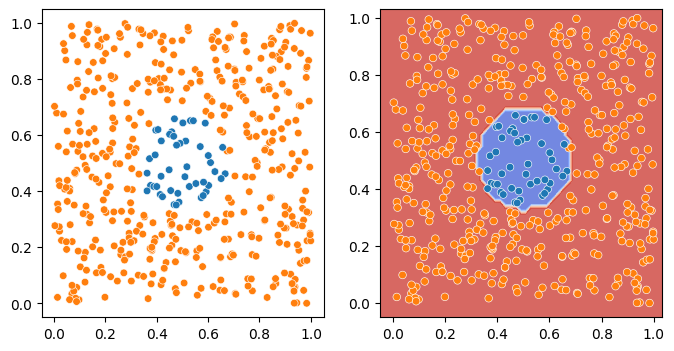

In [31]:
# Exercise 1
model = SVC(kernel="rbf")
model.fit(X, y1)
y_pred = model.predict(X)

make_plots(model, X, y1, 0.05)
print(f"Exercise 1\n\nBest kernel: rbf")
print(f"Accuracy Score: {round(accuracy_score(y1, y_pred), 2)}")

Exercise 2

Best kernel: rbf
Accuracy Score: 0.98


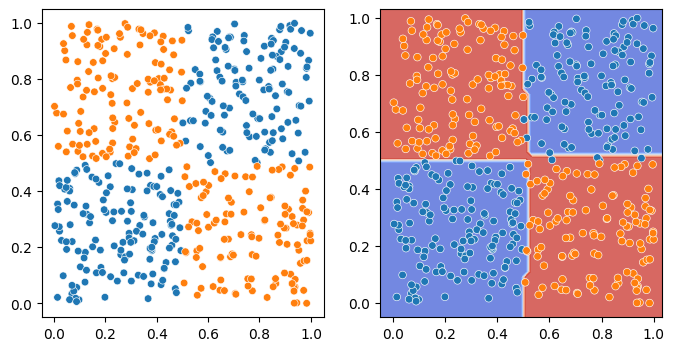

In [32]:
# Exercise 2
model = SVC(kernel="rbf")
model.fit(X, y2)
y_pred = model.predict(X)

make_plots(model, X, y2, 0.05)
print(f"Exercise 2\n\nBest kernel: rbf")
print(f"Accuracy Score: {round(accuracy_score(y2, y_pred), 2)}")

Exercise 3: we have two best performing Kernels

kernel: rbf
Accuracy Score: 1.0

kernel: Poly
Accuracy Score: 1.0


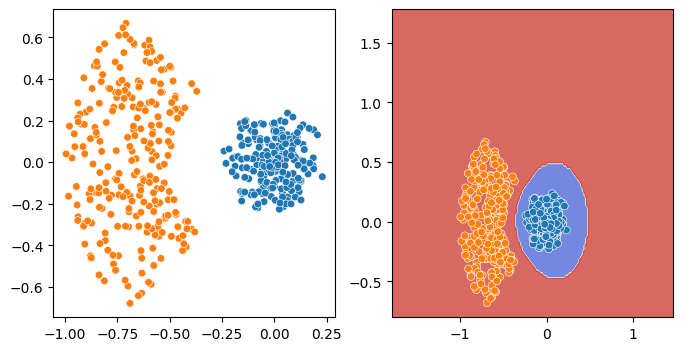

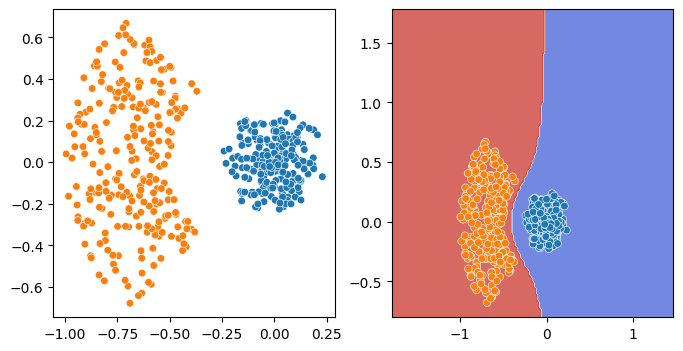

In [33]:
# Exercise 3

model = SVC(kernel="rbf")
model.fit(X3, y3)
y_pred = model.predict(X3)

make_plots(model, X3, y3, 0.8)
print(f"Exercise 3: we have two best performing Kernels\n\nkernel: rbf")
print(f"Accuracy Score: {round(accuracy_score(y3, y_pred), 2)}")

model = SVC(kernel="poly")
model.fit(X3, y3)
y_pred = model.predict(X3)

make_plots(model, X3, y3, 0.8)
print(f"\nkernel: Poly")
print(f"Accuracy Score: {round(accuracy_score(y3, y_pred), 2)}")

In [34]:
# Exercise 4

#model = SVC(kernel="rbf")
#model.fit(X4, y4)
#y_pred = model.predict(X4)

#make_plots(model, X4, y4, 2.5)
#print(f"Exercise 4\n\nBest kernel: rbf")
#print(f"Accuracy Score: {round(accuracy_score(y4, y_pred), 2)}")

Exercise 5

Best kernel: rbf
Accuracy Score: 1.0


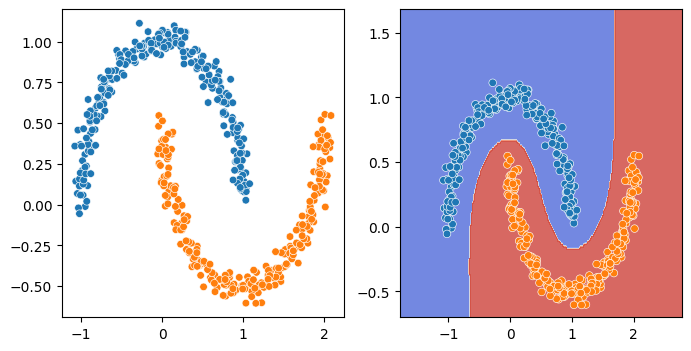

In [35]:
# Exercise 5

model = SVC(kernel="rbf")
model.fit(X5, y5)
y_pred = model.predict(X5)

make_plots(model, X5, y5, 0.7)
print(f"Exercise 5\n\nBest kernel: rbf")
print(f"Accuracy Score: {round(accuracy_score(y5, y_pred), 2)}")

# Task 2: Cats vs. Dogs with SVMs [30 marks]

In [36]:
# Get images

def load_image_files(container_path, dimension=(30, 30)):
    image_dir = Path(container_path)
    folders = [directory for directory in image_dir.iterdir() if directory.is_dir()]
    categories = [fo.name for fo in folders]

    descr = "Your own dataset"
    images = []
    flat_data = []
    target = []
    for i, direc in enumerate(folders):
        for file in direc.iterdir():
            img = skimage.io.imread(file)
            img_resized = resize(img, dimension, anti_aliasing=True, mode='reflect')
            flat_data.append(img_resized.flatten())
            images.append(img_resized)
            target.append(i)
    flat_data = np.array(flat_data)
    target = np.array(target)
    images = np.array(images)

    # return in the exact same format as the built-in datasets
    return Bunch(data=flat_data,
                 target=target,
                 target_names=categories,
                 images=images,
                 DESCR=descr)

image_dataset = load_image_files("images/")

In [37]:
X = image_dataset.data
y = image_dataset.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=seed)

In [38]:
scaler = MinMaxScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [39]:
model = SVC()

parameters = { 'C' : [0.01, 1, 10],
               'gamma' : [1, 10, 100],
               'kernel' : ['rbf', 'poly', 'sigmoid'] 
             }

grid = GridSearchCV(estimator=model, param_grid=parameters, scoring='precision_weighted')
grid.fit(X_train_scaled, y_train)
results = grid.cv_results_

print('Grid Search Results (Highest Weighted Precision):\n')
for i in range(27):
    print(f"{round(results['mean_test_score'][i], 2)} (+/- {round(results['std_test_score'][i], 2)}) for {results['params'][i]}")

Grid Search Results (Highest Weighted Precision):

0.54 (+/- 0.04) for {'C': 0.01, 'gamma': 1, 'kernel': 'rbf'}
0.56 (+/- 0.06) for {'C': 0.01, 'gamma': 1, 'kernel': 'poly'}
0.25 (+/- 0.0) for {'C': 0.01, 'gamma': 1, 'kernel': 'sigmoid'}
0.25 (+/- 0.01) for {'C': 0.01, 'gamma': 10, 'kernel': 'rbf'}
0.56 (+/- 0.06) for {'C': 0.01, 'gamma': 10, 'kernel': 'poly'}
0.25 (+/- 0.0) for {'C': 0.01, 'gamma': 10, 'kernel': 'sigmoid'}
0.25 (+/- 0.0) for {'C': 0.01, 'gamma': 100, 'kernel': 'rbf'}
0.56 (+/- 0.06) for {'C': 0.01, 'gamma': 100, 'kernel': 'poly'}
0.25 (+/- 0.0) for {'C': 0.01, 'gamma': 100, 'kernel': 'sigmoid'}
0.25 (+/- 0.01) for {'C': 1, 'gamma': 1, 'kernel': 'rbf'}
0.56 (+/- 0.06) for {'C': 1, 'gamma': 1, 'kernel': 'poly'}
0.25 (+/- 0.0) for {'C': 1, 'gamma': 1, 'kernel': 'sigmoid'}
0.25 (+/- 0.01) for {'C': 1, 'gamma': 10, 'kernel': 'rbf'}
0.56 (+/- 0.06) for {'C': 1, 'gamma': 10, 'kernel': 'poly'}
0.25 (+/- 0.0) for {'C': 1, 'gamma': 10, 'kernel': 'sigmoid'}
0.25 (+/- 0.0) for {'

In [40]:
y_pred = grid.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.55      0.62      0.58        50
           1       0.57      0.50      0.53        50

    accuracy                           0.56       100
   macro avg       0.56      0.56      0.56       100
weighted avg       0.56      0.56      0.56       100



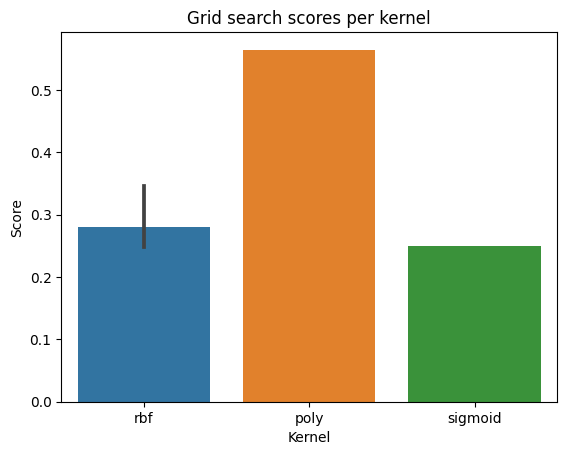

In [42]:
df = pd.DataFrame()
df['mean_test_score'] = results['mean_test_score']
df['parameters'] = results['params']

for i in range(27):
    df['parameters'][i] = df['parameters'][i].get('kernel')

df.groupby(['parameters']).mean()

ax = sns.barplot(data=df, y=df['mean_test_score'], x=df['parameters']).set_title('Grid search scores per kernel')
plt.xlabel('Kernel')
plt.ylabel('Score')
plt.show()

# I don't know why only one bar shows the std, I tried fixing it....

# Task 3: Cats vs. Dogs with MLPs [20 marks]

In [43]:
model = MLPClassifier(learning_rate='adaptive')

parameters = {
    'hidden_layer_sizes': [(50,50,50), (50,100,50), (100,)],
    'alpha': [0.0001, 0.05]
}



grid = GridSearchCV(estimator=model, param_grid=parameters, scoring='precision_weighted')
grid.fit(X_train_scaled, y_train)
results = grid.cv_results_

print('Grid Search Results (Highest Weighted Precision):\n')
for i in range(6):
    print(f"{round(results['mean_test_score'][i], 2)} (+/- {round(results['std_test_score'][i], 2)}) for {results['params'][i]}")

Grid Search Results (Highest Weighted Precision):

0.57 (+/- 0.11) for {'alpha': 0.0001, 'hidden_layer_sizes': (50, 50, 50)}
0.54 (+/- 0.1) for {'alpha': 0.0001, 'hidden_layer_sizes': (50, 100, 50)}
0.46 (+/- 0.13) for {'alpha': 0.0001, 'hidden_layer_sizes': (100,)}
0.55 (+/- 0.07) for {'alpha': 0.05, 'hidden_layer_sizes': (50, 50, 50)}
0.53 (+/- 0.1) for {'alpha': 0.05, 'hidden_layer_sizes': (50, 100, 50)}
0.56 (+/- 0.08) for {'alpha': 0.05, 'hidden_layer_sizes': (100,)}


In [44]:
y_pred = grid.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.56      0.58      0.57        50
           1       0.56      0.54      0.55        50

    accuracy                           0.56       100
   macro avg       0.56      0.56      0.56       100
weighted avg       0.56      0.56      0.56       100

